In [1]:
import numpy as np
import zipfile
from matplotlib.animation import FuncAnimation, FFMpegWriter
import matplotlib.pyplot as plt
from collections import Counter
from utils import remove_non_kanji

plt.style.use('seaborn-pastel')

In [2]:
# settings
max_kanji_rank = 2500
figure_size = (12, 8) # 
dpi = 150 # this results in a video with dimensions 1800*1200
          # dpi does affect the quality of the text rendering
fps = 60
font_family = 'Noto Sans JP' # font used for the kanji display
filename = 'kanji.mp4'
codec = 'libx264'
crf = '20'

In [3]:
# you need to change this function according to your purposes
# have it return a string or list of words
def get_text_data():
    archive = zipfile.ZipFile('corpus.zip', 'r')
    corpus = archive.read('corpus.txt')
    return corpus.decode('utf-8')

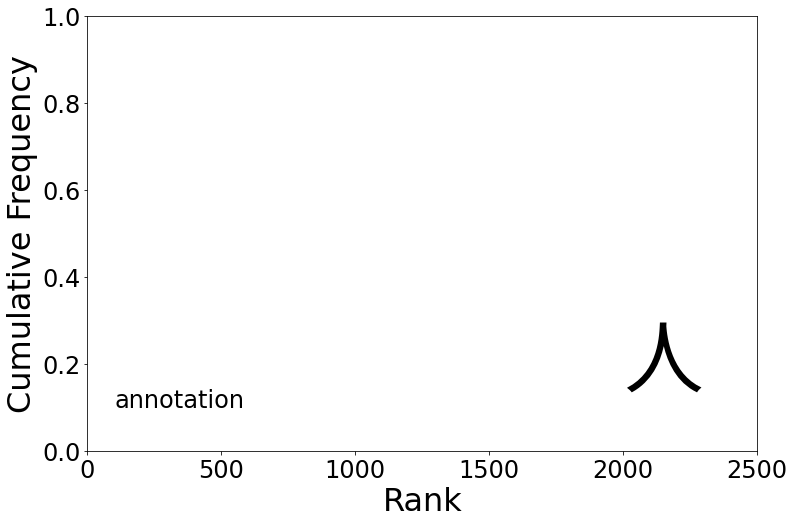

In [4]:
# calculate the cumulative values
corpus = remove_non_kanji(get_text_data())
kanji_counter = Counter(corpus)
val = [k for k,v in kanji_counter.most_common()]
count = [v for k,v in kanji_counter.most_common()]
count_cum = np.cumsum(np.array(count))/len(corpus)

if max_kanji_rank > len(count):
    max_kanji_rank = len(count)

# setup figure
fig = plt.figure()
fig.set_size_inches(figure_size[0], figure_size[1])
ax = plt.axes(xlim=(0, max_kanji_rank), ylim=(0, 1))
ax.tick_params(labelsize=24)

plt.xlabel('Rank', fontsize=32)
plt.ylabel('Cumulative Frequency', fontsize=32)



line, = ax.plot([], [], lw=4)
last_point, = ax.plot([],[], 'ro', ms=16)

annotation = ax.annotate(
    'annotation', xy=(100,0.1), fontsize=24)

kanji_display = ax.annotate(
    '人', xy=(int(max_kanji_rank*20/25),0.15), fontsize=80, family=font_family)


# actual data that will be plotted
x = np.arange(1,max_kanji_rank+1,1)
y = count_cum


def init():
    line.set_data([], [])
    last_point.set_data([], [])
    return line,


def update(i):

    new_x = x[:i+1]
    new_y = y[:i+1]
    line.set_data(new_x,new_y)
    last_point.set_data(new_x[-1], new_y[-1])
    # changes the position of the annotation according to the current frame
    # some magic numbers that kind of worked out
    if i < 400:
        annotation.set_position((new_x[-1]+50,new_y[-1]+0.1))
    elif i< int(max_kanji_rank*19/25):
        annotation.set_position((new_x[-1]+70,new_y[-1]-0.2))
    else:
        annotation.set_position((int(max_kanji_rank*20/25),0.75))
    annotation.set_text(f'Rank {i+1}\n{count_cum[i]:.3f}')
    kanji_display.set_text(f'{val[i]}')

    return line, annotation,

ani = FuncAnimation(
    fig, update, init_func=init, frames=max_kanji_rank, blit=True)

In [5]:
writer = FFMpegWriter(fps=fps, codec=codec, extra_args=['-crf', crf])
ani.save(filename, writer=writer, dpi=dpi)